In [1]:
import os,tifffile,timeit

In [2]:
os.getcwd()

'/Users/rubinlab_imaging/PycharmProjects/IMyG/Notebooks'

In [3]:
cd ../

/Users/rubinlab_imaging/PycharmProjects/IMyG


In [4]:
import IMyG as im

In [52]:
t1 = timeit.default_timer()
nd2 = im.IO.process_nd2_no_output("/Users/rubinlab_imaging/Desktop/PP1_filtered_raw_files/NDExp_WellB02_Point0002_Seq0178.nd2")
t2 = timeit.default_timer()
print(t2-t1)

34.087634193999975


In [6]:
import pickle

In [53]:
file = open("/Users/rubinlab_imaging/Desktop/pickeled.pk","wb")
pickle.dump(nd2.cells,file)

In [54]:
m = pickle.load(open("/Users/rubinlab_imaging/Desktop/pickeled.pk",'rb'))

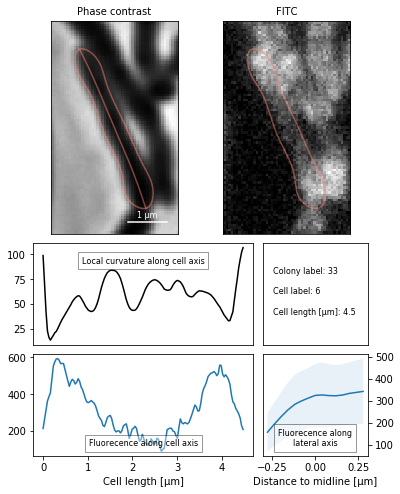

In [56]:
m[156].plot_advanced(nd2)

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

(1, 15)

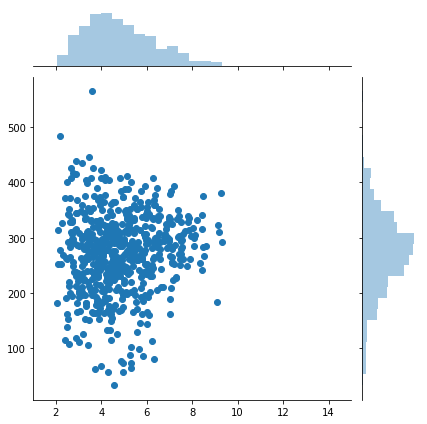

In [72]:
width,length,mean_fl = [],[],[]
for cell in m:
    if cell.is_good_baby:
        width.append(cell.width.mean()*cell.pixel_microns)
        length.append(cell.length)
        mean_fl.append(cell.mean_fl_intensity["FITC"])
a = sns.jointplot(length,mean_fl)
a.ax_marg_x.set_xlim(1,15)
#a.ax_marg_y.set_ylim(0.2,1.0)

In [214]:
from math import cos,sin,atan,pi
import numpy as np
import matplotlib.pyplot as plt
from IMyG.helper_func import distance

def unit_perpendicular_vector(data):
    d = data.copy()
    dxy = d[1:]-d[:-1]
    dxy_perp = np.vstack([np.ones(len(dxy)),-(dxy.T[0]/dxy.T[1])]).T
    dxy_perp = np.vstack([dxy_perp[0],dxy_perp])
    vector_length = np.sqrt(np.sum(np.square(dxy_perp),axis=1))
    dxy_unit = dxy_perp/np.vstack([vector_length,vector_length]).T
    return(dxy_unit)

def Straighten_measure(img,mask,midline,\
                       subpixel = 0.5,\
                       half_width_by_pixel = 6,\
                       remove_background = False):
    unit_dxy = unit_perpendicular_vector(midline)*subpixel
    data = bilinear_interpolate_numpy(img,midline.T[0],midline.T[1])
    copied_img = img.copy()
    if remove_background:
        copied_img[mask == 0] = 0
    for i in range(1,int(half_width_by_pixel/subpixel)):
        dxy = unit_dxy*i
        v1 = midline+dxy
        v2 = midline-dxy
        p1 = bilinear_interpolate_numpy(copied_img,v1.T[0],v1.T[1])
        p2 = bilinear_interpolate_numpy(copied_img,v2.T[0],v2.T[1])
        data = np.vstack([p1,data,p2])
    return (data)

def Straighten_measure_normalize_width(img,width,midline,\
                                       subpixel = 0.5,\
                                       remove_cap = 5,\
                                       remove_background = False,\
                                       pad = 2):
    decapped_midline = midline[remove_cap+1:-remove_cap-1]
    decapped_width = width[remove_cap:-remove_cap]
    unit_dxy = unit_perpendicular_vector(decapped_midline)*subpixel
    normalization_factor = decapped_width/decapped_width.mean()
    width_normalized_dxy = unit_dxy*(np.vstack([normalization_factor,normalization_factor]).T)
    data = bilinear_interpolate_numpy(img,decapped_midline.T[0],decapped_midline.T[1])
    copied_img = img.copy()
    if remove_background:
        copied_img[mask == 0] = 0
    for i in range(1,int(decapped_width.mean()*0.5/subpixel)+pad):
        dxy = width_normalized_dxy*i
        v1 = decapped_midline+dxy
        v2 = decapped_midline-dxy
        p1 = bilinear_interpolate_numpy(copied_img,v1.T[0],v1.T[1])
        p2 = bilinear_interpolate_numpy(copied_img,v2.T[0],v2.T[1])
        data = np.vstack([p1,data,p2])
    return (data)

In [218]:
a = Straighten_measure_normalize_width(cell.phase,cell.width,cell.midline)

In [220]:
a.shape

(19, 260)

In [222]:
np.average(a,axis = 1)

array([ 9191.53892308,  8035.29630769,  6964.04946154,  6042.88      ,
        5292.65315385,  4725.88873077,  4342.00365385,  4109.68253846,
        4003.74942308,  4011.34284615,  4120.43888462,  4342.58215385,
        4721.03730769,  5305.59592308,  6154.94753846,  7323.86080769,
        8788.20876923, 10470.95926923, 12312.692     ])

In [223]:
(a,b,c,d) = [1,2,3,4]

In [81]:
def line_intersect(a1, a2, b1, b2):
    #@Hamish Grubijan
    T = np.array([[0, -1], [1, 0]])
    da = np.atleast_2d(a2 - a1)
    db = np.atleast_2d(b2 - b1)
    dp = np.atleast_2d(a1 - b1)
    dap = np.dot(da, T)
    denom = np.sum(dap * db, axis=1)
    num = np.sum(dap * dp, axis=1)
    return np.atleast_2d(num / denom).T * db + b1

def vector_line_intersect(v1,v2,l1,l2):
    xy = line_intersect(v1,v2,l1,l2)
    dxy_v1 = xy-v1
    dxy_v2 = xy-v2
    dxy = dxy_v1*dxy_v2
    intersection_points = xy[np.where(np.logical_and(dxy[:,0]<0,dxy[:,1]<0))]
    if len(intersection_points)>2:
        sub_l1 = l1[np.where(np.logical_and(dxy[:,0]<0,dxy[:,1]<0))]
        dist = np.sum(np.square(sub_l1-intersection_points),axis = 1)
        intersection_points = intersection_points[np.argsort(dist)[0:2]]
    return(intersection_points)

def find_poles(midline,smoothed_contour):
    #find endpoints and their nearest neighbors on a midline
    length = len(midline)
    p2,p1 = smoothed_contour[1:],smoothed_contour[:-1]
    for i in range(5):
        pole1 = midline[i]
        pole1_neighbor = midline[i+1]
        #vectorize contour
        l1 = np.tile(pole1,(len(p2),1))
        l2 = np.tile(pole1_neighbor,(len(p2),1))
        #find the two intersection points between the vectorized contour and line through pole1
        intersection_points_pole1 = vector_line_intersect(p1,p2,l1,l2)
        dxy_1 = l1[0:2]-l2[0:2]
        ddxy_intersection_1 = (intersection_points_pole1-l1[0:2])*dxy_1
        index_1 = np.where(np.logical_and(ddxy_intersection_1[:,0]>0,ddxy_intersection_1[:,1]>0))[0]
        if len(index_1) > 0:
            extended_pole1 = intersection_points_pole1[index_1][0]
            break
    for j in range(5):
        pole2 = midline[-1-j]
        pole2_neighbor = midline[-2-j]
        #vectorize contour
        l3 = np.tile(pole2,(len(p2),1))
        l4 = np.tile(pole2_neighbor,(len(p2),1))
        #find the two intersection points between the vectorized contour and line through pole2
        intersection_points_pole2 = vector_line_intersect(p1,p2,l3,l4)
        dxy_2 = l3[0:2]-l4[0:2]
        ddxy_intersection_2 = (intersection_points_pole2-l3[0:2])*dxy_2
        index_2 = np.where(np.logical_and(ddxy_intersection_2[:,0]>0,ddxy_intersection_2[:,1]>0))[0]
        if len(index_2) > 0:
            extended_pole2 = intersection_points_pole2[index_2][0]
            break
    trimmed_midline = midline[i:length-j]
    return(extended_pole1,extended_pole2,trimmed_midline)

In [82]:
%%timeit
find_poles(cell.midline,cell.optimized_contour[0])

199 µs ± 3.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [111]:
from skimage import morphology

In [ ]:
morphology.dilation()